## Load Data

从Hdfs加载数据

In [6]:
df = spark.read.csv("hdfs://localhost:9000/user/hadoop/DataExpo2009/198*.csv",
                    header=True, inferSchema=True)

df2 = spark.read.csv("hdfs://localhost:9000/user/hadoop/DataExpo2009/2001.csv",
                    header=True, inferSchema=True)

In [7]:
df.printSchema()


root
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- DayofMonth: integer (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- DepTime: string (nullable = true)
 |-- CRSDepTime: integer (nullable = true)
 |-- ArrTime: string (nullable = true)
 |-- CRSArrTime: integer (nullable = true)
 |-- UniqueCarrier: string (nullable = true)
 |-- FlightNum: integer (nullable = true)
 |-- TailNum: string (nullable = true)
 |-- ActualElapsedTime: string (nullable = true)
 |-- CRSElapsedTime: integer (nullable = true)
 |-- AirTime: string (nullable = true)
 |-- ArrDelay: string (nullable = true)
 |-- DepDelay: string (nullable = true)
 |-- Origin: string (nullable = true)
 |-- Dest: string (nullable = true)
 |-- Distance: string (nullable = true)
 |-- TaxiIn: string (nullable = true)
 |-- TaxiOut: string (nullable = true)
 |-- Cancelled: integer (nullable = true)
 |-- CancellationCode: string (nullable = true)
 |-- Diverted: integer (nullable = true)
 |-- Car

In [3]:
from pyspark.sql.functions import *

df = df.withColumn('TotalDelay',col('ArrDelay')+col('DepDelay')) # 计算出总延误时间
each_flight_stats= df.groupby(['UniqueCarrier','FlightNum'])
total_delay_stats = each_flight_stats.mean('TotalDelay')
total_delay_stats.orderBy(desc('avg(TotalDelay)')).show(10) 


+-------------+---------+------------------+
|UniqueCarrier|FlightNum|   avg(TotalDelay)|
+-------------+---------+------------------+
|       PA (1)|     2238|             425.0|
|       PA (1)|      233|272.38461538461536|
|           US|     2099|             261.5|
|           UA|     1821|             243.0|
|           EA|     1602|238.66666666666666|
|           AS|     6062|             229.0|
|           PS|     1582|             204.0|
|           US|     2287|             192.0|
|           EA|     1855|             189.5|
|           US|      779|             183.5|
+-------------+---------+------------------+
only showing top 10 rows



In [12]:

from pyspark.sql.functions import *

unique_carrier_stats = df.groupby('UniqueCarrier')

# 进行聚合统计
unique_carrier_stats = unique_carrier_stats.agg(
    count(when(col('ArrDelay') > 0, True)).alias('DelayCount'),
    count('*').alias('TotalFlights')
)

# 显示每个航空公司延误航班和准时航班数量结果
unique_carrier_stats.show()


+-------------+----------+------------+
|UniqueCarrier|DelayCount|TotalFlights|
+-------------+----------+------------+
|           UA|    711254|     1314442|
|           EA|    320028|      667772|
|           PI|    584091|      873957|
|           PS|     47913|       83617|
|           AA|    758305|     1583130|
|           NW|    555198|      991465|
|           HP|    248258|      421858|
|           TW|    349491|      621940|
|           DL|   1074239|     1723116|
|           US|    816132|     1301539|
|           AS|    123354|      200350|
|           CO|    469970|      990355|
|       PA (1)|     94252|      168382|
|           WN|    277632|      613199|
+-------------+----------+------------+



In [13]:
unique_carrier_delay_stats = unique_carrier_stats.withColumn('DelayRate', 
        (col('DelayCount') / col('TotalFlights')) * 100)

unique_carrier_delay_stats.show()

+-------------+----------+------------+------------------+
|UniqueCarrier|DelayCount|TotalFlights|         DelayRate|
+-------------+----------+------------+------------------+
|           UA|    711254|     1314442|54.110717703786094|
|           EA|    320028|      667772|47.924740779787115|
|           PI|    584091|      873957| 66.83292198586429|
|           PS|     47913|       83617| 57.30054893143739|
|           AA|    758305|     1583130|47.899098621086075|
|           NW|    555198|      991465| 55.99774071701976|
|           HP|    248258|      421858| 58.84871212588122|
|           TW|    349491|      621940|  56.1936842782262|
|           DL|   1074239|     1723116|62.342813832614866|
|           US|    816132|     1301539|62.705151363117054|
|           AS|    123354|      200350|61.569253805839786|
|           CO|    469970|      990355| 47.45470058716319|
|       PA (1)|     94252|      168382|55.975104227292704|
|           WN|    277632|      613199| 45.2760033855241

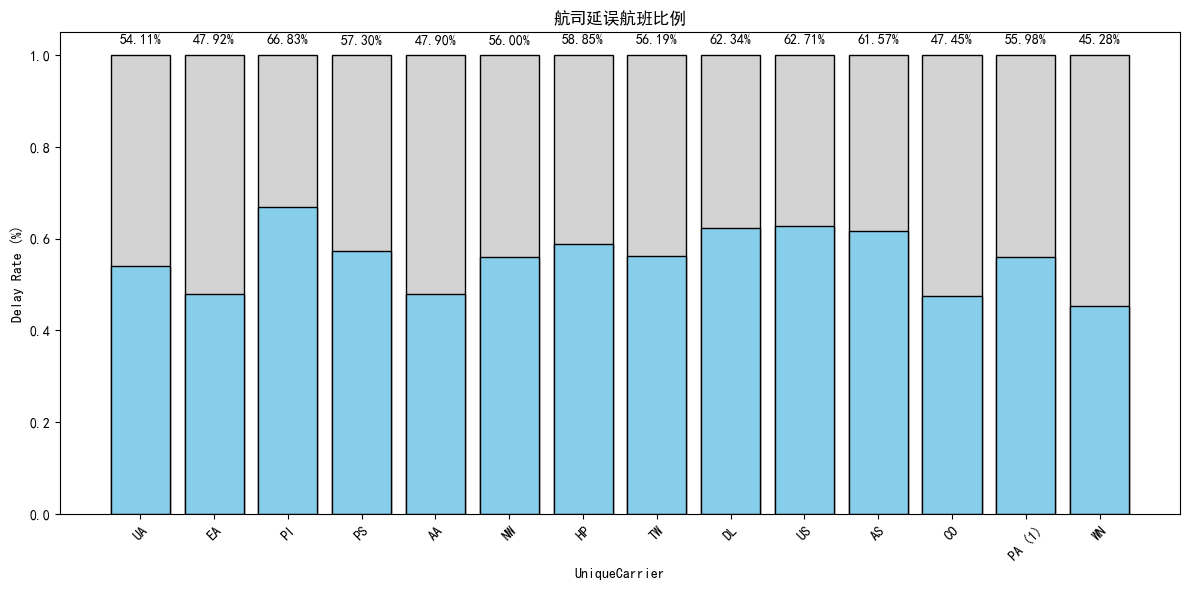

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 将 PySpark DataFrame 转换为 Pandas DataFrame
unique_carrier_delay_stats_pd = unique_carrier_delay_stats.toPandas()
plt.rcParams['font.sans-serif']=['SimHei'] 

carriers = unique_carrier_delay_stats_pd['UniqueCarrier']
delay_rates = unique_carrier_delay_stats_pd['DelayRate']

x = np.arange(len(carriers))
height = 1 

fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.bar(x, height, color='lightgray', edgecolor='black') 

for i, rate in enumerate(delay_rates):
    ax.bar(x[i], height * (rate / 100), color='skyblue', edgecolor='black')  # 蓝色部分表示延误比例

ax.set_xlabel('UniqueCarrier')
ax.set_ylabel('Delay Rate (%)')
ax.set_title('航司延误航班比例')
ax.set_xticks(x)
ax.set_xticklabels(carriers, rotation=45)

for i, rate in enumerate(delay_rates):
    ax.text(x[i], height + 0.02, f'{rate:.2f}%', ha='center', va='bottom')

plt.tight_layout()

plt.savefig('delay_rate_by_unique_carrier.png', dpi=300)

plt.show()

In [24]:
# 添加Hour
df = df.withColumn('Hour', (col('CRSDepTime') / 100).cast('int'))
df2 = df2.withColumn('Hour', (col('CRSDepTime') / 100).cast('int'))

In [16]:
# 分析一天中延误最严重的飞行时间

# Step 1: 添加 'Hour' 列
df_with_hour = df.withColumn('Hour', (col('CRSDepTime') / 100).cast('int'))


# Step 2: 分组统计
delay_by_hour = df_with_hour.groupBy('Hour') \
    .agg(
        count('*').alias('TotalFlights'), 
        count(when(col('ArrDelay') > 0, True)).alias('DelayFlights')
    )

# Step 3: 计算延误率
delay_by_hour = delay_by_hour.withColumn('DelayRate', col('DelayFlights') / col('TotalFlights'))

# Step 4: 排序并显示结果
delay_by_hour = delay_by_hour.orderBy(desc('DelayRate'))

# 显示最终结果
delay_by_hour.show(24)
        



+----+------------+------------+-------------------+
|Hour|TotalFlights|DelayFlights|          DelayRate|
+----+------------+------------+-------------------+
|  16|      746919|      448303| 0.6002029671222716|
|  17|      790991|      465943| 0.5890623281427981|
|  20|      639281|      376476| 0.5889053483522895|
|  18|      778040|      456205| 0.5863516014600791|
|  15|      675097|      390495|  0.578427988866785|
|  19|      599414|      342133|  0.570779127614637|
|  14|      657151|      370889|  0.564389310828105|
|  13|      790020|      445752|  0.564228753702438|
|  11|      720692|      399677| 0.5545739372714003|
|  12|      756775|      419639| 0.5545095966436523|
|  21|      381657|      208564| 0.5464697359147087|
|   9|      772889|      421655| 0.5455569946007771|
|  22|      176049|       95093| 0.5401507534834052|
|  10|      622678|      334448| 0.5371122795409505|
|   8|      876885|      464543| 0.5297650204986971|
|   7|      845122|      441199| 0.52205362066

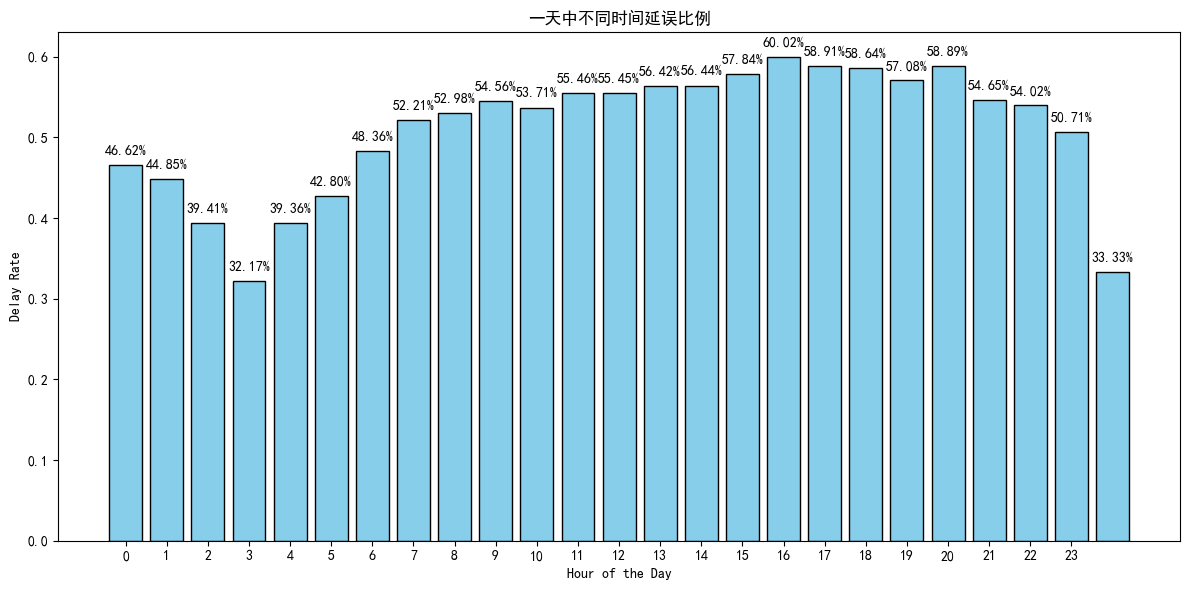

In [27]:
import matplotlib.pyplot as plt

# 将 PySpark DataFrame 转换为 Pandas DataFrame
delay_by_hour_pd = delay_by_hour.toPandas()

hours = delay_by_hour_pd['Hour']
delay_rates = delay_by_hour_pd['DelayRate']

fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(hours, delay_rates, color='skyblue', edgecolor='black')

ax.set_xlabel('Hour of the Day')
ax.set_ylabel('Delay Rate')
ax.set_title('一天中不同时间延误比例')

ax.set_xticks(range(24))
ax.set_xticklabels(range(24))

for i, rate in enumerate(delay_rates):
    ax.text(hours[i], rate + 0.01, f'{rate:.2%}', ha='center', va='bottom')

plt.tight_layout()

plt.savefig('delay_rate_by_hour.png', dpi=300)

plt.show()

In [18]:
delay_by_day_of_week = df.groupBy('DayOfWeek') \
    .agg((count('*')).alias('TotalFlights'),(count(when(col('ArrDelay')>0,True))).alias('DelayFlights')) \
    .withColumn('DelayRate',col('DelayFlights')/col('TotalFlights')) \
    .orderBy(desc('DelayRate'))
delay_by_day_of_week.show() 

+---------+------------+------------+------------------+
|DayOfWeek|TotalFlights|DelayFlights|         DelayRate|
+---------+------------+------------+------------------+
|        4|     1685334|     1006515|0.5972198982516225|
|        3|     1683378|      989605|0.5878685595273313|
|        5|     1682825|      984940|0.5852896171616181|
|        2|     1682782|      960769|0.5709408586495458|
|        1|     1680068|      906798|0.5397388677124973|
|        7|     1601490|      822913| 0.513842109535495|
|        6|     1539245|      758577|0.4928240793375973|
+---------+------------+------------+------------------+



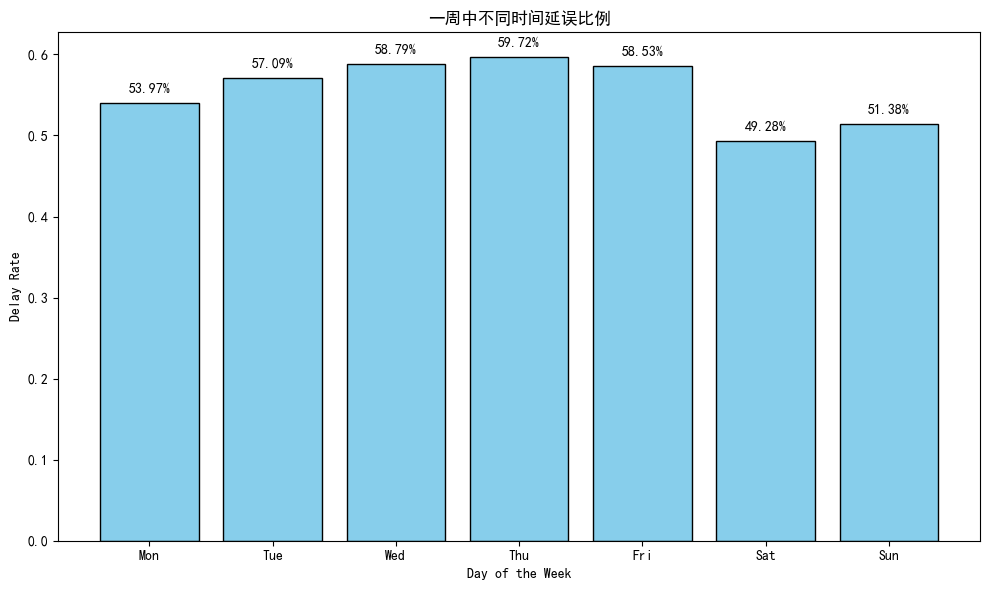

In [26]:
import matplotlib.pyplot as plt

delay_by_day_of_week_pd = delay_by_day_of_week.toPandas()

days = delay_by_day_of_week_pd['DayOfWeek']
delay_rates = delay_by_day_of_week_pd['DelayRate']

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(days, delay_rates, color='skyblue', edgecolor='black')

ax.set_xlabel('Day of the Week')
ax.set_ylabel('Delay Rate')
ax.set_title('一周中不同时间延误比例')

ax.set_xticks(range(1, 8))
ax.set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])

for i, rate in enumerate(delay_rates):
    ax.text(days[i], rate + 0.01, f'{rate:.2%}', ha='center', va='bottom')

plt.tight_layout()

plt.savefig('delay_rate_by_day_of_week.png', dpi=300)

plt.show()

In [20]:
# 短途航班和长途航班，哪种航班取消更严重？

from pyspark.sql.functions import *
# 定义短途航班和长途航班, 距离小于500英里为短途，否则为长途
df = df.withColumn("FlightType",
                   when(col("Distance") < 500, "ShortHaul")
                   .otherwise("LongHaul"))

# 按航班类型分组，计算取消率
cancellation_rate = df.groupBy("FlightType") \
                      .agg(avg("Cancelled").alias("CancellationRate"))

cancellation_rate.show()

+----------+--------------------+
|FlightType|    CancellationRate|
+----------+--------------------+
| ShortHaul|0.013601172842271953|
|  LongHaul|0.011058593239437926|
+----------+--------------------+



### 解释：

- **目的**：选择对航班取消预测有潜在影响的特征列。
- **特征说明**：
    - **时间相关**：`Year`、`Month`、`DayofMonth`、`DayOfWeek`、`DepTime`、`CRSDepTime`、`ArrTime`、`CRSArrTime`。
    - **航班信息**：`UniqueCarrier_index`（编码后的航空公司）、`FlightNum`（航班号）。
    - **飞行时间**：`ActualElapsedTime`、`CRSElapsedTime`、`AirTime`。
    - **延误信息**：`ArrDelay`、`DepDelay`。
    - **机场信息**：`Origin_index`、`Dest_index`（编码后的出发地和目的地机场）。
    - **距离和地面时间**：`Distance`、`TaxiIn`、`TaxiOut`。
    - **其他信息**：`Diverted`（是否改航）、`CarrierDelay`、`WeatherDelay`、`NASDelay`、`SecurityDelay`、`LateAircraftDelay`（各种延误原因）。
- **输出**：`feature_columns` 是一个包含所有选定特征列的列表。

In [25]:
from pyspark.sql.types import FloatType, IntegerType
from pyspark.sql.functions import col
# 编码分类变量
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline

for column in ["features",   "UniqueCarrier_index","Origin_index", "Dest_index" ]:
    if column in df.columns:
        df = df.drop(column)

indexers = [StringIndexer(inputCol=column, outputCol=column+"_index").fit(df) for column in ["UniqueCarrier", "Origin", "Dest"]]

stages = []
stages += indexers

string_columns = ["DepTime", "ArrTime", "ActualElapsedTime", "CRSElapsedTime", 
                  "AirTime", "ArrDelay", "DepDelay", "Distance", "TaxiIn", "TaxiOut",
                  "CarrierDelay", "WeatherDelay", "NASDelay", "SecurityDelay", "LateAircraftDelay"]

for column in string_columns:
    df = df.withColumn(column, col(column).cast(FloatType()))
df = df.na.fill(0, subset=string_columns)
df = df.withColumn("Cancelled", col("Cancelled").cast(IntegerType()))
# 将特征列组合成特征向量

from pyspark.ml.feature import VectorAssembler

feature_columns = ["Month", "DayofMonth", "DayOfWeek","Hour",
                   "UniqueCarrier_index", "Origin_index", "Dest_index",
                   "ArrDelay", "DepDelay",
                   "Distance",
                   "Diverted"]

assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

stages.append(assembler)

pipeline = Pipeline(stages=stages)
df = pipeline.fit(df).transform(df)

df.select("features").show(10, truncate=False)

+-----------------------------------------------------+
|features                                             |
+-----------------------------------------------------+
|[10.0,14.0,3.0,7.0,13.0,26.0,6.0,23.0,11.0,447.0,0.0]|
|[10.0,15.0,4.0,7.0,13.0,26.0,6.0,14.0,-1.0,447.0,0.0]|
|[10.0,17.0,6.0,7.0,13.0,26.0,6.0,29.0,11.0,447.0,0.0]|
|[10.0,18.0,7.0,7.0,13.0,26.0,6.0,-2.0,-1.0,447.0,0.0]|
|[10.0,19.0,1.0,7.0,13.0,26.0,6.0,33.0,19.0,447.0,0.0]|
|[10.0,21.0,3.0,7.0,13.0,26.0,6.0,-1.0,-2.0,447.0,0.0]|
|[10.0,22.0,4.0,7.0,13.0,26.0,6.0,3.0,-2.0,447.0,0.0] |
|[10.0,23.0,5.0,7.0,13.0,26.0,6.0,13.0,1.0,447.0,0.0] |
|[10.0,24.0,6.0,7.0,13.0,26.0,6.0,19.0,14.0,447.0,0.0]|
|[10.0,25.0,7.0,7.0,13.0,26.0,6.0,2.0,-1.0,447.0,0.0] |
+-----------------------------------------------------+
only showing top 10 rows



In [30]:
from pyspark.sql.types import FloatType, IntegerType
from pyspark.sql.functions import col
# 编码分类变量
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline

for column in ["features",   "UniqueCarrier_index","Origin_index", "Dest_index" ]:
    if column in df2.columns:
        df2 = df2.drop(column)

indexers = [StringIndexer(inputCol=column, outputCol=column+"_index").fit(df2) for column in ["UniqueCarrier", "Origin", "Dest"]]

stages = []
stages += indexers

string_columns = ["DepTime", "ArrTime", "ActualElapsedTime", "CRSElapsedTime", 
                  "AirTime", "ArrDelay", "DepDelay", "Distance", "TaxiIn", "TaxiOut",
                  "CarrierDelay", "WeatherDelay", "NASDelay", "SecurityDelay", "LateAircraftDelay"]

for column in string_columns:
    df2 = df2.withColumn(column, col(column).cast(FloatType()))
df2 = df2.na.fill(0, subset=string_columns)
df2 = df2.withColumn("Cancelled", col("Cancelled").cast(IntegerType()))
# 将特征列组合成特征向量

from pyspark.ml.feature import VectorAssembler

feature_columns = ["Month", "DayofMonth", "DayOfWeek","Hour",
                   "UniqueCarrier_index", "Origin_index", "Dest_index",
                   "ArrDelay", "DepDelay",
                   "Distance",
                   "Diverted"]

assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

stages.append(assembler)

pipeline = Pipeline(stages=stages)
df2 = pipeline.fit(df2).transform(df2)

df2.select("features").show(10, truncate=False)

+--------------------------------------------------------+
|features                                                |
+--------------------------------------------------------+
|[1.0,17.0,3.0,1810.0,4.0,19.0,12.0,-3.0,-4.0,361.0,0.0] |
|[1.0,18.0,4.0,1810.0,4.0,19.0,12.0,4.0,-5.0,361.0,0.0]  |
|[1.0,19.0,5.0,1810.0,4.0,19.0,12.0,23.0,11.0,361.0,0.0] |
|[1.0,20.0,6.0,1810.0,4.0,19.0,12.0,10.0,-3.0,361.0,0.0] |
|[1.0,21.0,7.0,1810.0,4.0,19.0,12.0,20.0,0.0,361.0,0.0]  |
|[1.0,22.0,1.0,1810.0,4.0,19.0,12.0,-3.0,-3.0,361.0,0.0] |
|[1.0,23.0,2.0,1810.0,4.0,19.0,12.0,-10.0,-8.0,361.0,0.0]|
|[1.0,24.0,3.0,1810.0,4.0,19.0,12.0,-12.0,-6.0,361.0,0.0]|
|[1.0,25.0,4.0,1810.0,4.0,19.0,12.0,-9.0,2.0,361.0,0.0]  |
|[1.0,26.0,5.0,1810.0,4.0,19.0,12.0,-1.0,2.0,361.0,0.0]  |
+--------------------------------------------------------+
only showing top 10 rows



In [21]:
train_data, test_data = df.randomSplit([0.8, 0.2], seed=2021091201012)

In [22]:
# 划分训练集和测试集
train_data = df
test_data = df2

In [49]:
from pyspark.ml.classification import LinearSVC
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator


svm = LinearSVC(featuresCol="features", labelCol="Cancelled")
svm_model = svm.fit(train_data)

# 在测试集上进行预测
svm_predictions = svm_model.transform(test_data)
svm_predictions.select(["features", "rawPrediction", "prediction", "Cancelled"]).show()
# 评估模型性能
evaluator_accuracy = MulticlassClassificationEvaluator(labelCol="Cancelled", predictionCol="prediction", metricName="accuracy")
evaluator_recall = MulticlassClassificationEvaluator(labelCol="Cancelled", predictionCol="prediction", metricName="weightedRecall")
evaluator_auc = BinaryClassificationEvaluator(labelCol="Cancelled", rawPredictionCol="rawPrediction", metricName="areaUnderROC")

svm_accuracy = evaluator_accuracy.evaluate(svm_predictions)
svm_recall = evaluator_recall.evaluate(svm_predictions)
svm_auc = evaluator_auc.evaluate(svm_predictions)

print(f"SVM 模型的准确率为: {svm_accuracy:.4f}")
print(f"SVM 模型的召回率为: {svm_recall:.4f}")
print(f"SVM 模型的 AUC 值为: {svm_auc:.4f}")

+--------------------+--------------------+----------+---------+
|            features|       rawPrediction|prediction|Cancelled|
+--------------------+--------------------+----------+---------+
|[1.0,17.0,3.0,181...|[1.00000145349568...|       0.0|        0|
|[1.0,18.0,4.0,181...|[1.00000140018609...|       0.0|        0|
|[1.0,19.0,5.0,181...|[1.00000139545426...|       0.0|        0|
|[1.0,20.0,6.0,181...|[1.00000126118172...|       0.0|        0|
|[1.0,21.0,7.0,181...|[1.00000122001657...|       0.0|        0|
|[1.0,22.0,1.0,181...|[1.00000192451147...|       0.0|        0|
|[1.0,23.0,2.0,181...|[1.00000181452782...|       0.0|        0|
|[1.0,24.0,3.0,181...|[1.00000172478490...|       0.0|        0|
|[1.0,25.0,4.0,181...|[1.00000165528271...|       0.0|        0|
|[1.0,26.0,5.0,181...|[1.00000160602126...|       0.0|        0|
|[1.0,27.0,6.0,181...|[1.00000150413390...|       0.0|        0|
|[1.0,28.0,7.0,181...|[1.00000144677616...|       0.0|        0|
|[1.0,29.0,1.0,181...|[1.

SVM 模型的准确率为: 0.9613
SVM 模型的召回率为: 0.9613
SVM 模型的 AUC 值为: 0.5394


In [53]:
# DEBUG
svm_predictions.show()
selected_columns = ["features", "Cancelled", "rawPrediction", "prediction"]
svm_predictions.select(selected_columns).show()

+----+-----+----------+---------+-------+----------+-------+----------+-------------+---------+-------+-----------------+--------------+-------+--------+--------+------+----+--------+------+-------+---------+----------------+--------+------------+------------+--------+-------------+-----------------+-------------------+------------+----------+--------------------+--------------------+----------+
|Year|Month|DayofMonth|DayOfWeek|DepTime|CRSDepTime|ArrTime|CRSArrTime|UniqueCarrier|FlightNum|TailNum|ActualElapsedTime|CRSElapsedTime|AirTime|ArrDelay|DepDelay|Origin|Dest|Distance|TaxiIn|TaxiOut|Cancelled|CancellationCode|Diverted|CarrierDelay|WeatherDelay|NASDelay|SecurityDelay|LateAircraftDelay|UniqueCarrier_index|Origin_index|Dest_index|            features|       rawPrediction|prediction|
+----+-----+----------+---------+-------+----------+-------+----------+-------------+---------+-------+-----------------+--------------+-------+--------+--------+------+----+--------+------+-------+----

In [52]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator

# 初始化随机森林模型
rf = RandomForestClassifier(featuresCol="features", labelCol="Cancelled", maxBins=256)

rf_model = rf.fit(train_data)

rf_predictions = rf_model.transform(test_data)

evaluator_accuracy = MulticlassClassificationEvaluator(labelCol="Cancelled", predictionCol="prediction", metricName="accuracy")
evaluator_recall = MulticlassClassificationEvaluator(labelCol="Cancelled", predictionCol="prediction", metricName="weightedRecall")
evaluator_auc = BinaryClassificationEvaluator(labelCol="Cancelled", rawPredictionCol="rawPrediction", metricName="areaUnderROC")

rf_accuracy = evaluator_accuracy.evaluate(rf_predictions)
rf_recall = evaluator_recall.evaluate(rf_predictions)
rf_auc = evaluator_auc.evaluate(rf_predictions)

rf_predictions.select(["features", "rawPrediction", "prediction", "Cancelled"]).show(10)
print(f"随机森林模型的准确率为: {rf_accuracy:.4f}")
print(f"随机森林模型的召回率为: {rf_recall:.4f}")
print(f"随机森林模型的 AUC 值为: {rf_auc:.4f}")

+--------------------+--------------------+----------+---------+
|            features|       rawPrediction|prediction|Cancelled|
+--------------------+--------------------+----------+---------+
|[1.0,17.0,3.0,181...|[19.7282426159755...|       0.0|        0|
|[1.0,18.0,4.0,181...|[19.8165778739159...|       0.0|        0|
|[1.0,19.0,5.0,181...|[19.8165778739159...|       0.0|        0|
|[1.0,20.0,6.0,181...|[19.8165778739159...|       0.0|        0|
|[1.0,21.0,7.0,181...|[19.8165778739159...|       0.0|        0|
|[1.0,22.0,1.0,181...|[19.7282426159755...|       0.0|        0|
|[1.0,23.0,2.0,181...|[19.7282426159755...|       0.0|        0|
|[1.0,24.0,3.0,181...|[19.7282426159755...|       0.0|        0|
|[1.0,25.0,4.0,181...|[19.7282426159755...|       0.0|        0|
|[1.0,26.0,5.0,181...|[19.7282426159755...|       0.0|        0|
+--------------------+--------------------+----------+---------+
only showing top 10 rows

随机森林模型的准确率为: 0.9613
随机森林模型的召回率为: 0.9613
随机森林模型的 AUC 值为: 0.9852


# 线性判别分析

在 PySpark 中，线性判别分析（Linear Discriminant Analysis, LDA） 主要用于降维，而不是分类。PySpark 的 MLlib 提供了 LinearDiscriminantAnalysis 类来实现 LDA 降维。如果你需要将 LDA 用于分类任务，可以结合其他分类器（如逻辑回归）来实现。

以下是使用 线性判别分析（LDA） 进行降维，并结合逻辑回归进行分类的完整代码示例：

1. 使用 LDA 进行降维
首先，使用 LDA 将高维特征降维到低维空间。

2. 结合逻辑回归进行分类
将 LDA 降维后的特征作为输入，使用逻辑回归进行分类。

In [59]:
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator

gbt = GBTClassifier(featuresCol="features", labelCol="Cancelled", maxIter=10, maxBins=256)
gbt_model = gbt.fit(train_data)

gbt_predictions = gbt_model.transform(test_data)

evaluator_accuracy = MulticlassClassificationEvaluator(labelCol="Cancelled", predictionCol="prediction", metricName="accuracy")
evaluator_recall = MulticlassClassificationEvaluator(labelCol="Cancelled", predictionCol="prediction", metricName="weightedRecall")
evaluator_auc = BinaryClassificationEvaluator(labelCol="Cancelled", rawPredictionCol="rawPrediction", metricName="areaUnderROC")

gbt_accuracy = evaluator_accuracy.evaluate(gbt_predictions)
gbt_recall = evaluator_recall.evaluate(gbt_predictions)
gbt_auc = evaluator_auc.evaluate(gbt_predictions)

gbt_predictions.select("features", "rawPrediction", "prediction", "Cancelled").show(10)

print(f"GBT 模型的准确率为: {gbt_accuracy:.4f}")
print(f"GBT 模型的召回率为: {gbt_recall:.4f}")
print(f"GBT 模型的 AUC 值为: {gbt_auc:.4f}")

+--------------------+--------------------+----------+---------+
|            features|       rawPrediction|prediction|Cancelled|
+--------------------+--------------------+----------+---------+
|[1.0,17.0,3.0,181...|[1.32592221604603...|       0.0|        0|
|[1.0,18.0,4.0,181...|[1.32590267852133...|       0.0|        0|
|[1.0,19.0,5.0,181...|[1.32590267852134...|       0.0|        0|
|[1.0,20.0,6.0,181...|[1.32590267852133...|       0.0|        0|
|[1.0,21.0,7.0,181...|[1.32590267852134...|       0.0|        0|
|[1.0,22.0,1.0,181...|[1.32592221604603...|       0.0|        0|
|[1.0,23.0,2.0,181...|[1.32592221604603...|       0.0|        0|
|[1.0,24.0,3.0,181...|[1.32592221604603...|       0.0|        0|
|[1.0,25.0,4.0,181...|[1.32592221604603...|       0.0|        0|
|[1.0,26.0,5.0,181...|[1.32592221604603...|       0.0|        0|
+--------------------+--------------------+----------+---------+
only showing top 10 rows

GBT 模型的准确率为: 0.9695
GBT 模型的召回率为: 0.9695
GBT 模型的 AUC 值为: 0.9963
